Import dataset

In [1]:
import nltk
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

Prepare data

In [0]:

import numpy as np
from nltk.corpus import brown

sents = np.random.permutation(brown.tagged_sents(tagset='universal'))

In [3]:
sents[:2]

array([list([('From', 'ADP'), ('even', 'ADV'), ('a', 'DET'), ('cursory', 'ADJ'), ('inspection', 'NOUN'), ('of', 'ADP'), ('its', 'DET'), ('many', 'ADJ'), ('aspects', 'NOUN'), (',', '.'), ('however', 'ADV'), (',', '.'), ('the', 'DET'), ('historian', 'NOUN'), ('can', 'VERB'), ('deduce', 'VERB'), ('several', 'ADJ'), ('fundamental', 'ADJ'), ('conclusions', 'NOUN'), ('about', 'ADP'), ('the', 'DET'), ('progress', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('Aegean', 'ADJ'), ('world', 'NOUN'), ('down', 'PRT'), ('to', 'ADP'), ('800', 'NUM'), ('B.C.', 'NOUN')]),
       list([('my', 'DET'), ('nerves', 'NOUN'), ('are', 'VERB'), ('as', 'ADV'), ('strong', 'ADJ'), ('.', '.')])],
      dtype=object)

In [4]:
len(sents)

57340

Train set = 70%, test = 30%

In [0]:
TRAIN_SIZE = 1000
TEST_SIZE = 200

In [6]:
TRAIN_SIZE

1000

In [7]:
TEST_SIZE

200

In [0]:
def prepare_sent(sent):
    return tuple(zip(*sent))

training_data = list(map(prepare_sent, sents[:TRAIN_SIZE]))
test_data = list(map(prepare_sent, sents[TRAIN_SIZE:TRAIN_SIZE+TEST_SIZE]))

In [0]:
class Ent2Idx:
    def __init__(self, e2idict):
        self.e2i = e2idict
        self.i2e = sorted(e2idict, key = lambda x: e2idict[x], reverse=True)

    def __len__(self):
        return len(self.e2i)

    def index(self, item):
        return self.e2i[item]

    def entity(self, idx):
        return self.i2e[idx]

    def indices(self, seq):
        e2i = self.e2i
        return torch.tensor([e2i[x] for x in seq], dtype=torch.long)

    def entities(self, vec):
        i2e = self.i2e
        return list(map(lambda x: i2e[x], vec))

In [0]:
def build_seq2vec_indices(dataset):
  word2idx = dict()
  tag2idx = dict()

  for sent, tags in dataset:
   for word in sent:
     if word not in word2idx:
       word2idx[word] = len(word2idx)
   for tag in tags:
     if tag not in tag2idx:
       tag2idx[tag] = len(tag2idx)
  return (Ent2Idx(word2idx), Ent2Idx(tag2idx))

In [0]:
EMBEDDING_DIM = 32
HIDDEN_DIM = 32

In [0]:
word2idx, tag2idx = build_seq2vec_indices(training_data + test_data)


Model

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, word2idx, tag2idx):
        super(LSTMTagger, self).__init__()

        # Save some parameters
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = len(word2idx)
        self.tagset_size = len(tag2idx)

        # Create embedding layer that turns words into a vector of specified size
        # Takes vocab size, the output shape will be embedding dimension
        self.word_embeddings = nn.Embedding(
            num_embeddings = self.vocab_size,
            embedding_dim = self.embedding_dim
        )

        # Takes embedded word vectors (size is specified) as inputs
        # outputs hidden states of size hidden_dim
        self.lstm = nn.LSTM(self.embedding_dim,self.hidden_dim)

        # Linear layer that maps the hidden state output dimension
        # to the number of the tags we want as output (number of tags)
        self.hidden2tag = nn.Linear(self.hidden_dim, self.tagset_size)

    # Defines feedforward behavior of the model
    def forward(self, sentence):
        sentlen = len(sentence)

        # create embedded word vctors for each word in a sentence
        embeds = self.word_embeddings(sentence)

        # get the output and hidden state by passing the lstm over our word embeddings
        # lstm takes in embeddings and hidden state
        lstm_out, _ = self.lstm(embeds.view(sentlen, 1, -1))

        # the scores for the most likely tag for a word
        tag_output = self.hidden2tag(lstm_out.view(sentlen, -1))
        tag_scores = F.log_softmax(tag_output, dim=1)

        return tag_scores

Train model

In [0]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, word2idx, tag2idx).cuda()
#model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, word2idx, tag2idx)

In [0]:
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
EPOCHS = 100

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

Epoch: 20, loss: 0.00734
Epoch: 40, loss: 0.00571
Epoch: 60, loss: 0.00470
Epoch: 80, loss: 0.00404
Epoch: 100, loss: 0.00358


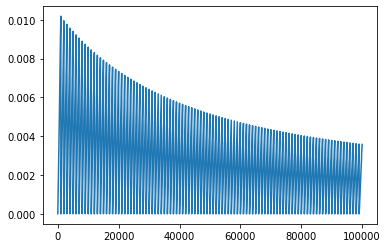

In [20]:
l_loss = []

for epoch in range(EPOCHS):
  #print(epoch, end=' ')

  epoch_loss = 0.0

  # get all sentences and corresponding tags in the training data
  for sentence, tags in training_data:

      # zero gradients
      model.zero_grad()

      # forward pass to get tag scores
      #tag_scores = model(word2idx.indices(sentence))
      tag_scores = model(word2idx.indices(sentence).cuda())

      # calculate the loss and gradients
      loss = loss_function(tag_scores, tag2idx.indices(tags).cuda())
      #loss = loss_function(tag_scores, tag2idx.indices(tags))
      epoch_loss += loss.item()
      loss.backward()

      # update the model parameters with the optimizer
      optimizer.step()
      l_loss.append(epoch_loss/len(training_data))

  # avg loss per 20 epochs
  if (epoch % 20 == 19):
      print('Epoch: %s, loss: %1.5f' % (epoch + 1, epoch_loss/len(training_data)))

plt.plot(l_loss)

Text:  ) other deductions . 
Expected:  . ADJ NOUN . 
Actual:  VERB NUM . VERB
Correctly predicted:  0  out of  4
Text:  Shakespeare gives us a vivid picture of Shylock , but probably he never saw a Jew , unless in some of his travels . 
Expected:  NOUN VERB PRON DET ADJ NOUN ADP NOUN . CONJ ADV PRON ADV VERB DET NOUN . ADP ADP DET ADP DET NOUN . 
Actual:  PRT . DET PRON PRT PRT CONJ PRT VERB ADP X DET X . PRON PRT VERB X CONJ PRON CONJ PRON PRT VERB
Correctly predicted:  0  out of  24
Text:  The award is the first such honor in the 11-year history of JA activities in Portland , according to Ralph Scolatti , local executive director for Junior Achievement . 
Expected:  DET NOUN VERB DET ADJ ADJ NOUN ADP DET ADJ NOUN ADP NOUN NOUN ADP NOUN . ADP ADP NOUN NOUN . ADJ NOUN NOUN ADP ADJ NOUN . 
Actual:  PRON . . PRON NUM NUM PRT CONJ PRON NUM PRT CONJ PRT PRT CONJ PRT VERB X CONJ . PRT VERB NUM PRT PRT CONJ NUM PRT VERB
Correctly predicted:  0  out of  29
Text:  If a nation wished to get a 

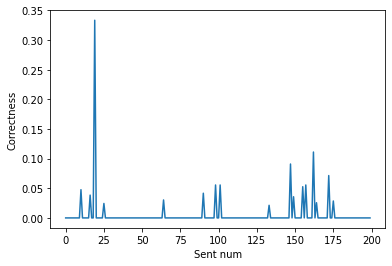

In [21]:
def calc_diff(text, expected, actual):
  l_text = list(text)
  l_expected = list(expected)
  l_actual = list(actual)

  #print(len(l_text), ' ', len(l_expected), ' ', len(l_actual))
  correct = 0
  for idx in range(0, len(l_text)):
    if l_expected[idx] == l_actual[idx]:
      correct += 1
  
  total = len(l_expected)
  print('Text: ', ' '.join(l_text), '\nExpected: ', ' '.join(l_expected), 
          '\nActual: ', ' '.join(l_actual))
  print('Correctly predicted: ', correct, ' out of ', total);
  print('============================================================')
  return correct / total

with torch.no_grad():
  correct = []
  for sent, tags in test_data:
    raw = model(word2idx.indices(sent).cuda())
    #raw = model(word2idx.indices(sent))
    predicted_tags = tag2idx.entities(raw.argmax(1))
    correct.append(calc_diff(sent, tags, predicted_tags))
  plt.plot(correct)
  plt.ylabel('Correctness')
  plt.xlabel('Sent num')

Testing quality of model

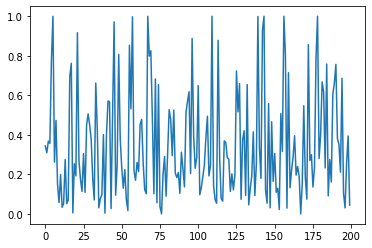

In [22]:
import math

with torch.no_grad():
  loss_val = []
  for sent, tags in test_data:
    pred = model(word2idx.indices(sent).cuda())
    # pred = model(word2idx.indices(sent))
    loss = loss_function(pred, tag2idx.indices(tags).cuda())
    #loss = loss_function(pred, tag2idx.indices(tags))
    loss_val.append(loss.neg().exp().item())
  plt.plot(loss_val)